In [1]:
# Install all required packages from PyPI
!pip install kagglehub ultralytics deep_sort_realtime opencv-python tqdm

import cv2
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort
from ultralytics import YOLO
import torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 108.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
import kagglehub
import shutil
import glob
import os

path = kagglehub.dataset_download("mrriandmstique/wildtrack-multi-camera-tracking")

def find_wildtrack_root(base):
    for root, dirs, files in os.walk(base):
        if "Wildtrack" in dirs:
            return os.path.join(root, "Wildtrack")
    return None

WILDTRACK_BASE = find_wildtrack_root(path)
WILDTRACK_INPUT = os.path.join(WILDTRACK_BASE, "Image_subsets")

CAMERA_MAP = {
    "C1": "cam01",
    "C2": "cam02",
    "C3": "cam03",
    "C4": "cam04",
    "C5": "cam05",
    "C6": "cam06",
    "C7": "cam07",
}

NORMALIZED = "/content/Wildtrack_frames"
if os.path.exists(NORMALIZED):
    shutil.rmtree(NORMALIZED)
os.makedirs(NORMALIZED)

for c_old, c_new in CAMERA_MAP.items():
    shutil.copytree(os.path.join(WILDTRACK_INPUT, c_old),
                    os.path.join(NORMALIZED, c_new))

sample = glob.glob(os.path.join(NORMALIZED, "cam01", "*"))[0]
ext = os.path.splitext(sample)[1].lower()
FRAME_EXT = "*" + ext

CAMERA_DIRS = {
    cam: os.path.join(NORMALIZED, cam)
    for cam in sorted(os.listdir(NORMALIZED))
}

100%|██████████| 6.33G/6.33G [01:11<00:00, 95.7MB/s]

Extracting files...


In [3]:
import os

def load_camera_frames(cam_dir):
    # Load all image frames, sorted by filename
    frames = sorted([
        os.path.join(cam_dir, f)
        for f in os.listdir(cam_dir)
        if f.lower().endswith(('.jpg', '.png'))
    ])
    return frames

CAMERA_DIRS = {
    cam: os.path.join(NORMALIZED, cam)
    for cam in sorted(os.listdir(NORMALIZED))
}

# Dictionary: cam name -> list of frame filepaths
camera_dict = {cam: load_camera_frames(path) for cam, path in CAMERA_DIRS.items()}

# Optional: check loaded frames count per camera
for cam, frames in camera_dict.items():
    print(f"{cam}: {len(frames)} frames loaded")


cam01: 401 frames loaded
cam02: 401 frames loaded
cam03: 401 frames loaded
cam04: 401 frames loaded
cam05: 401 frames loaded
cam06: 401 frames loaded
cam07: 401 frames loaded


In [13]:
import cv2
import numpy as np
import os
import re

# Mapping of Wildtrack camera name to calibration file shortname
CAMERA_FILES = {
    "cam01": ("CVLab1",),
    "cam02": ("CVLab2",),
    "cam03": ("CVLab3",),
    "cam04": ("CVLab4",),
    "cam05": ("IDIAP1",),
    "cam06": ("IDIAP2",),
    "cam07": ("IDIAP3",),
}

# Correct parser for OpenCV XML-style camera_matrix
def parse_opencv_camera_matrix(file_path):
    with open(file_path) as f:
        content = f.read()
    m = re.search(r'<camera_matrix[^>]*>.*?<data>(.*?)</data>.*?</camera_matrix>', content, re.DOTALL)
    if not m:
        raise ValueError(f"camera_matrix tag not found in {file_path}")
    numbers = list(map(float, m.group(1).split()))
    return np.array(numbers).reshape(3,3)

# Parser for simple OpenCV XML-format vector/matrix (rvec or tvec)
def parse_opencv_matrix(file_path, tag):
    with open(file_path) as f:
        content = f.read()
    m = re.search(f'<{tag}[^>]*>(.*?)</{tag}>', content, re.DOTALL)
    if not m:
        return None
    numbers = list(map(float, m.group(1).replace('\n', ' ').split()))
    return np.array(numbers)

# Load homographies for all cameras
H_cam_to_world = {}

for cam_name, (shortname,) in CAMERA_FILES.items():
    intr_file = os.path.join(WILDTRACK_BASE, 'calibrations', 'intrinsic_original', f'intr_{shortname}.xml')
    extr_file = os.path.join(WILDTRACK_BASE, 'calibrations', 'extrinsic', f'extr_{shortname}.xml')
    K = parse_opencv_camera_matrix(intr_file)
    rvec = parse_opencv_matrix(extr_file, 'rvec')
    tvec = parse_opencv_matrix(extr_file, 'tvec')
    R, _ = cv2.Rodrigues(rvec)
    Rt = np.column_stack((R[:, :2], tvec.reshape(3,1)))  # 3x3: r1, r2, t for Z=0 plane
    H = K @ Rt
    H_cam_to_world[cam_name] = H

print("Homographies for all cameras loaded!")
for cam, H in H_cam_to_world.items():
    print(f"{cam}: \n{H}\n")


Homographies for all cameras loaded!
cam01: 
[[     1100.1      1634.6        5244]
 [     27.826       43.37  5.1729e+05]
 [   -0.46017     0.85627      986.72]]

cam02: 
[[    -918.19     -1719.1  4.0365e+06]
 [     12.401      34.313  2.7246e+05]
 [    0.52823    -0.81212      2040.5]]

cam03: 
[[    -1938.4     -44.266  1.9024e+06]
 [     58.913     -68.086  5.4697e+05]
 [   -0.41202    -0.88021      1992.8]]

cam04: 
[[     56.624      1974.1  1.1744e+06]
 [      17.63      27.113  4.9798e+05]
 [   -0.82215     0.48972      1106.9]]

cam05: 
[[     561.21     -1861.4  1.9915e+06]
 [     189.57     -55.405  4.2841e+05]
 [    0.96787    -0.20081      600.29]]

cam06: 
[[     2003.3      92.588  4.5512e+05]
 [     57.848      74.173   4.882e+05]
 [    0.44876     0.88059      1044.1]]

cam07: 
[[    -119.72      1948.8 -1.4388e+05]
 [     193.99      11.207   3.831e+05]
 [   -0.85718     0.38324      1052.8]]



In [14]:
def is_valid_world_point(X, Y):
    # Bounds for Wildtrack plaza
    return (-700 <= X <= 1200) and (-500 <= Y <= 2200)


In [28]:
from ultralytics import YOLO
import torch
import cv2

# Ensure YOLO uses GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("YOLO device:", device)

# Download and load YOLOv8 person model (nano version for speed/reasonable recall)
person_model = YOLO('yolov8n.pt')
person_model.to(device)

def detect_people_in_frame(image, conf=0.70, iou=0.45, min_area=1800, min_w=35, min_h=35):
    """
    Runs YOLOv8 person detection on a given image,
    keeps only high-confidence, reasonably-sized boxes.
    Returns list of [x1, y1, x2, y2] for each detection.
    """
    results = person_model.predict(
        image,
        classes=[0],  # person class only
        conf=conf,
        iou=iou,
        device=device
    )[0].boxes.xyxy.cpu().numpy()

    detections = []
    for x1, y1, x2, y2, *rest in results:
        w, h = x2 - x1, y2 - y1
        area = w * h
        if area > min_area and w > min_w and h > min_h:
            detections.append([int(x1), int(y1), int(x2), int(y2)])
    return detections


YOLO device: cuda


In [29]:
# Set number of frames in your test subset
# Example: use the minimum across all cameras (for safety)
n_test_frames = min(len(frames) for frames in camera_dict.values())
print(f"Number of test frames: {n_test_frames}")


Number of test frames: 401


In [30]:
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np

trackers = {cam: DeepSort(max_age=3, n_init=3, nms_max_overlap=0.5) for cam in camera_dict}
MIN_TRACK_FRAMES = 4  # Lowered to catch brief tracks

def bbox_xyxy_to_xywh(b):
    x1, y1, x2, y2 = b
    w, h = x2 - x1, y2 - y1
    return [x1, y1, w, h]

tracks_per_cam = {cam: [] for cam in camera_dict}
n_test_frames = min(len(frames) for frames in camera_dict.values())
for frame_idx in range(n_test_frames):
    for cam in camera_dict:
        img_path = camera_dict[cam][frame_idx]
        image = cv2.imread(img_path)
        detections = detect_people_in_frame(image)
        detection_inputs = [[bbox_xyxy_to_xywh(b), 1.0, 0] for b in detections]
        outputs = trackers[cam].update_tracks(detection_inputs, frame=image)
        for trk in outputs:
            if not trk.is_confirmed():
                continue
            tracks_per_cam[cam].append({
                "frame": frame_idx,
                "track_id": int(trk.track_id),
                "bbox": trk.to_tlbr()
            })
for cam in tracks_per_cam:
    tids = [t['track_id'] for t in tracks_per_cam[cam]]
    good_ids = set(id for id in tids if tids.count(id) >= MIN_TRACK_FRAMES)
    tracks_per_cam[cam] = [t for t in tracks_per_cam[cam] if t['track_id'] in good_ids]


Streaming output truncated to the last 5000 lines.
0: 384x640 7 persons, 7.2ms
Speed: 3.0ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 11.6ms
Speed: 5.7ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 7.6ms
Speed: 4.1ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 8.4ms
Speed: 3.1ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 8.2ms
Speed: 3.7ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.9

In [31]:
MIN_TRACK_FRAMES = 5
for cam in tracks_per_cam:
    tids = [t['track_id'] for t in tracks_per_cam[cam]]
    good_ids = set(id for id in tids if tids.count(id) >= MIN_TRACK_FRAMES)
    tracks_per_cam[cam] = [t for t in tracks_per_cam[cam] if t['track_id'] in good_ids]


In [32]:
import collections
EDGE_THRESH = 40
WINDOW = 2  # Stricter
def at_edge(bbox, img_width):
    x1, _, x2, _ = bbox
    return (x1 < EDGE_THRESH) or (x2 > img_width - EDGE_THRESH)

def edge_tracks_match(t1, t2, img_width, spatial_thresh=250):  # tighter matching
    b1, b2 = t1['bbox'], t2['bbox']
    at1 = at_edge(b1, img_width)
    at2 = at_edge(b2, img_width)
    if not (at1 and at2): return False
    pt1 = t1.get('worldXY', None)
    pt2 = t2.get('worldXY', None)
    if pt1 is not None and pt2 is not None:
        dist = np.linalg.norm(np.array(pt1) - np.array(pt2))
        return dist <= spatial_thresh
    return False

cam_track_to_gid = {}
gid_counter = 0
tracks_by_frame_cam = collections.defaultdict(lambda: collections.defaultdict(list))
sample_img = cv2.imread(camera_dict["cam01"][0])
img_width = sample_img.shape[1]
for cam, tracks in tracks_per_cam.items():
    for track in tracks:
        frame_idx = track["frame"]
        tracks_by_frame_cam[frame_idx][cam].append(track)
for frame_idx in range(n_test_frames):
    for cam in camera_dict.keys():
        for track in tracks_by_frame_cam[frame_idx][cam]:
            key = (cam, track["track_id"])
            if key in cam_track_to_gid:
                continue
            # Get projected world coords
            bbox = track['bbox']
            u = (bbox[0] + bbox[2]) / 2.0
            v = bbox[3]
            Hinv = np.linalg.inv(H_cam_to_world[cam])
            pt_img = np.array([u, v, 1.0])
            pt_ground = Hinv @ pt_img
            Xw, Yw = pt_ground[0] / pt_ground[2], pt_ground[1] / pt_ground[2]
            track['worldXY'] = (Xw, Yw)
            # Edge association w/ spatial check!
            if at_edge(track["bbox"], img_width):
                match_found = False
                for offset in range(-WINDOW, WINDOW+1):
                    neighbor_frame = frame_idx + offset
                    if neighbor_frame < 0 or neighbor_frame >= n_test_frames:
                        continue
                    for neighbor_cam in camera_dict.keys():
                        if neighbor_cam == cam: continue
                        for neighbor_track in tracks_by_frame_cam[neighbor_frame][neighbor_cam]:
                            neighbor_key = (neighbor_cam, neighbor_track["track_id"])
                            if neighbor_key in cam_track_to_gid:
                                continue
                            # Compute worldXY for neighbor if not present
                            bbox_n = neighbor_track['bbox']
                            u_n = (bbox_n[0] + bbox_n[2]) / 2.0
                            v_n = bbox_n[3]
                            Hinv_n = np.linalg.inv(H_cam_to_world[neighbor_cam])
                            pt_img_n = np.array([u_n, v_n, 1.0])
                            pt_ground_n = Hinv_n @ pt_img_n
                            Xw_n, Yw_n = pt_ground_n[0] / pt_ground_n[2], pt_ground_n[1] / pt_ground_n[2]
                            neighbor_track['worldXY'] = (Xw_n, Yw_n)
                            if edge_tracks_match(track, neighbor_track, img_width):
                                cam_track_to_gid[key] = gid_counter
                                cam_track_to_gid[neighbor_key] = gid_counter
                                gid_counter += 1
                                match_found = True
                                break
                        if match_found: break
                    if match_found: break
                if not match_found:
                    cam_track_to_gid[key] = gid_counter
                    gid_counter += 1
            else:
                cam_track_to_gid[key] = gid_counter
                gid_counter += 1
print("Total unique global IDs assigned:", gid_counter)


Total unique global IDs assigned: 580


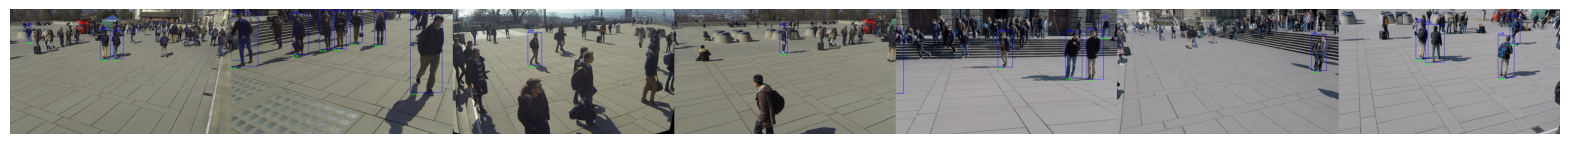

In [33]:
import cv2
import numpy as np

# Helper: annotate a single frame
def annotate_frame(img, bbox, local_id, global_id):
    x1, y1, x2, y2 = [int(float(v)) for v in bbox]
    color = (255, 0, 0)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    cv2.putText(img, f"L:{local_id}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    cv2.putText(img, f"G:{global_id}", (x1, y2+20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    return img

# For one frame index, gather and stitch all annotated camera views
def stitch_and_annotate(frame_idx, tracks_by_cam, cam_track_to_gid):
    annotated_frames = []
    for cam in sorted(camera_dict.keys()):
        frame_path = camera_dict[cam][frame_idx]
        img = cv2.imread(frame_path)
        # Find all tracks for this frame in this camera
        for t in tracks_by_cam[cam]:
            if t["frame"] == frame_idx:
                local_id = t["track_id"]
                key = (cam, local_id)
                gid = cam_track_to_gid.get(key, -1)
                img = annotate_frame(img, t["bbox"], local_id, gid)
        annotated_frames.append(img)
    # Stitch all camera frames horizontally
    stitched = cv2.hconcat(annotated_frames)
    return stitched

# Choose a frame index for preview (e.g., 100)
frame_idx = 100
stitched_frame = stitch_and_annotate(frame_idx, tracks_per_cam, cam_track_to_gid)

# Show with OpenCV in a notebook (if running in Colab/Jupyter), or save using cv2.imwrite
from matplotlib import pyplot as plt
plt.figure(figsize=(20,5))
plt.imshow(cv2.cvtColor(stitched_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


Fused (X, Y) world coordinates for frame 100:
GID 128: (X=262.48, Y=454.21)
GID 131: (X=325.45, Y=512.42)
GID 110: (X=669.21, Y=1977.01)
GID 116: (X=-41.08, Y=1910.82)
GID 123: (X=423.35, Y=1585.52)
GID 126: (X=554.42, Y=2006.71)
GID 127: (X=294.40, Y=1394.13)
GID 129: (X=506.78, Y=1775.96)
GID 132: (X=427.17, Y=1417.85)
GID 133: (X=475.29, Y=1635.03)


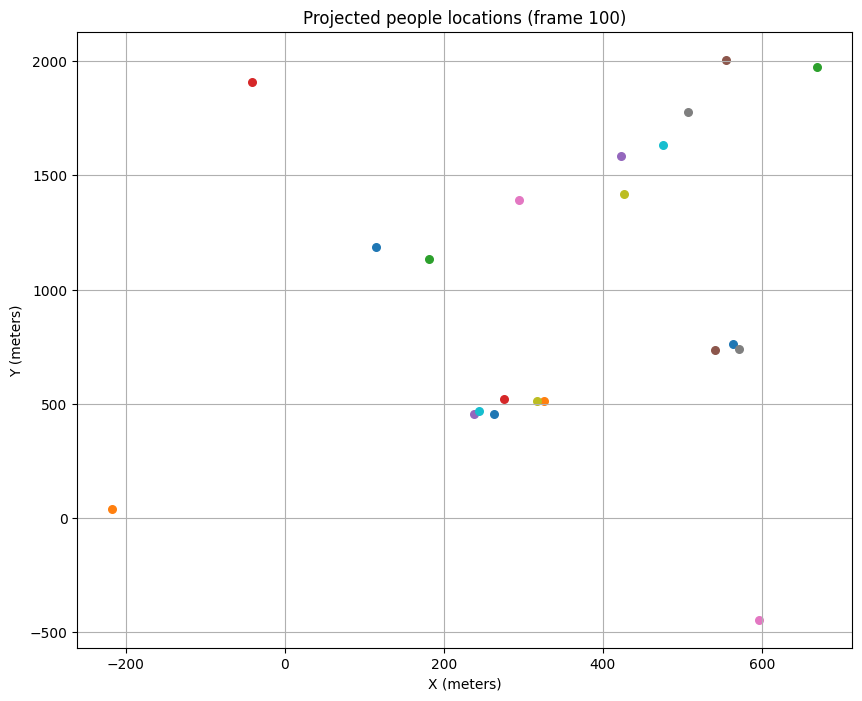

In [34]:
import numpy as np
from collections import defaultdict

def is_valid_world_point(X, Y):
    # Tune these bounds to your venue -- these work for Wildtrack:
    return (-700 <= X <= 1200) and (-500 <= Y <= 2200)

# Choose a frame to project (e.g., frame_idx = 100)
frame_idx = 100

# Project detections to world for this frame
world_detections = []

for cam in camera_dict.keys():
    # Inverse homography: pixel -> ground plane
    Hinv = np.linalg.inv(H_cam_to_world[cam])
    for t in tracks_per_cam[cam]:
        if t['frame'] != frame_idx:
            continue
        bbox = t['bbox']
        # Project bottom center of box
        u = (bbox[0] + bbox[2]) / 2.0
        v = bbox[3]
        pt_img = np.array([u, v, 1.0])
        pt_ground = Hinv @ pt_img
        Xw = pt_ground[0] / pt_ground[2]
        Yw = pt_ground[1] / pt_ground[2]
        if not is_valid_world_point(Xw, Yw):
            continue   # <--- Filtering out-of-bounds projections
        key = (cam, t["track_id"])
        gid = cam_track_to_gid.get(key, -1)
        world_detections.append({
            'gid': gid, 'cam': cam, 'X': Xw, 'Y': Yw,
            'local_id': t['track_id']
        })

# Fuse: For each global ID, take the mean (X, Y) across all cameras (simple fusion)
fused_world = defaultdict(list)
for det in world_detections:
    fused_world[det['gid']].append((det['X'], det['Y']))

fused_coords = {
    gid: (np.mean([x for x, _ in pts]), np.mean([y for _, y in pts]))
    for gid, pts in fused_world.items()
}

# Example: Print first 10 projected people for this frame
print(f"Fused (X, Y) world coordinates for frame {frame_idx}:")
for gid, (X, Y) in list(fused_coords.items())[:10]:
    print(f"GID {gid}: (X={X:.2f}, Y={Y:.2f})")

# Optional: Scatter plot of all GIDs in the world for this frame
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
for gid, (X, Y) in fused_coords.items():
    plt.scatter(X, Y, label=f'GID {gid}', s=30)
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.title(f"Projected people locations (frame {frame_idx})")
plt.grid(True)
plt.show()


In [35]:
from collections import defaultdict
import pandas as pd

def is_valid_world_point(X, Y):
    return (-700 <= X <= 1200) and (-500 <= Y <= 2200)

all_tracks_world = []
for frame_idx in range(n_test_frames):
    frame_detections = []
    for cam in camera_dict.keys():
        Hinv = np.linalg.inv(H_cam_to_world[cam])
        for t in tracks_per_cam[cam]:
            if t['frame'] != frame_idx: continue
            bbox = t['bbox']
            u = (bbox[0] + bbox[2]) / 2.0
            v = bbox[3]
            pt_img = np.array([u, v, 1.0])
            pt_ground = Hinv @ pt_img
            Xw, Yw = pt_ground[0] / pt_ground[2], pt_ground[1] / pt_ground[2]
            if not is_valid_world_point(Xw, Yw): continue
            key = (cam, t["track_id"])
            gid = cam_track_to_gid.get(key, -1)
            frame_detections.append({'gid': gid, 'X': Xw, 'Y': Yw, 'cam': cam, 'local_id': t['track_id']})
    by_gid = defaultdict(list)
    for d in frame_detections:
        by_gid[d['gid']].append((d['X'], d['Y']))
    for gid, xy_list in by_gid.items():
        X = np.mean([x for x, _ in xy_list])
        Y = np.mean([y for _, y in xy_list])
        all_tracks_world.append({'frame': frame_idx, 'gid': gid, 'X': X, 'Y': Y})

df_tracks = pd.DataFrame(all_tracks_world)
csv_out = '/content/wildtrack_argus_tracks_world.csv'
df_tracks.to_csv(csv_out, index=False)
print(f"Exported tracking results for all frames to {csv_out}")
print(df_tracks.head(10))


Exported tracking results for all frames to /content/wildtrack_argus_tracks_world.csv
   frame  gid           X            Y
0      2    0  324.285193  1529.488086
1      2    1  229.271909  1612.709777
2      2    2  350.731998  1594.003912
3      2    3  356.555102   648.076256
4      2    4  563.960723  1493.279054
5      2    5  741.680001  1391.382313
6      2    6  609.461792  1466.649709
7      2    7 -210.315699  -230.640064
8      2    8   77.933501   994.416732
9      3    0  295.106841  1593.854948


In [36]:
import os
import json

gt_anno_dir = os.path.join(WILDTRACK_BASE, "annotations_positions")
gt_annos = {}
for fn in sorted(os.listdir(gt_anno_dir)):
    if not fn.endswith('.json'):
        continue
    frame_name = fn.split(".")[0]  # e.g., '00000070'
    fpath = os.path.join(gt_anno_dir, fn)
    with open(fpath, 'r') as f:
        gt_annos[frame_name] = json.load(f)

# List keys and investigate structure
print("Available keys:", list(gt_annos.keys())[:5])
test_key = list(gt_annos.keys())[0]
print("GT annotation for key:", test_key)
print("Type and keys:", type(gt_annos[test_key]), getattr(gt_annos[test_key], "keys", lambda: [])())


Available keys: ['00000000', '00000005', '00000010', '00000015', '00000020']
GT annotation for key: 00000000
Type and keys: <class 'list'> []


In [37]:
import numpy as np
import pandas as pd

gt_world = []

# Map from viewNum to camera name string as in your H_cam_to_world dict
VIEWNUM_TO_CAM = {
    0: "cam01",
    1: "cam02",
    2: "cam03",
    3: "cam04",
    4: "cam05",
    5: "cam06",
    6: "cam07",
}

for frame_key, people in gt_annos.items():
    frame_idx = int(frame_key)  # match your detection CSV
    for person in people:
        pid = person.get('personID', -1)
        # Pick the FIRST valid view with a visible bbox
        for v in person["views"]:
            # Use only views with valid bbox
            if min(v['xmin'], v['xmax'], v['ymin'], v['ymax']) < 0:
                continue
            cam = VIEWNUM_TO_CAM[v['viewNum']]
            u = (v['xmin'] + v['xmax']) / 2.0
            v_img = v['ymax']  # bottom y
            Hinv = np.linalg.inv(H_cam_to_world[cam])
            pt_img = np.array([u, v_img, 1.0])
            pt_ground = Hinv @ pt_img
            Xw = pt_ground[0] / pt_ground[2]
            Yw = pt_ground[1] / pt_ground[2]
            gt_world.append({'frame': frame_idx, 'gtid': pid, 'X': Xw, 'Y': Yw})
            break  # Only use one valid view per person (short-circuit for uniqueness)

df_gt_world = pd.DataFrame(gt_world)
print("Sample projected GTs in world plane:")
print(df_gt_world.head(10))


Sample projected GTs in world plane:
   frame  gtid           X            Y
0      0   122  571.947032  1490.054790
1      0    14  302.837307  1447.550810
2      0    20  348.108886  1515.738000
3      0    25 -304.947339   295.316491
4      0    26 -222.794410  -234.208993
5      0    33 -235.134821   624.666672
6      0     5  847.837278  1060.709858
7      0    27  -82.611925  1674.595585
8      0    28 -208.723759  -187.035720
9      0    23  615.106935  1533.109522


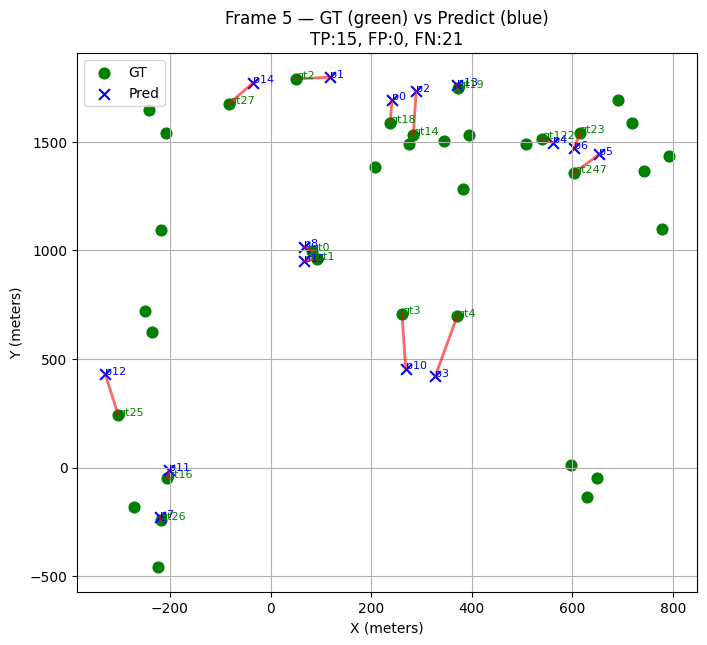

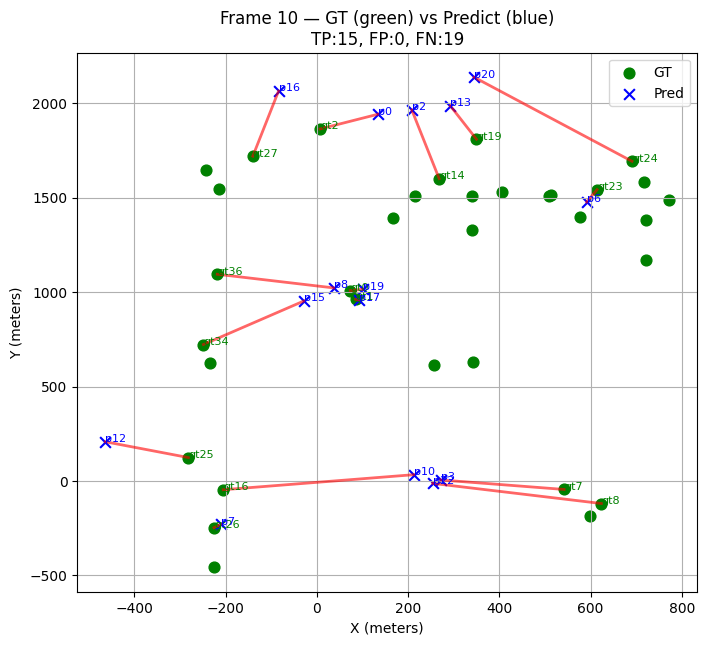

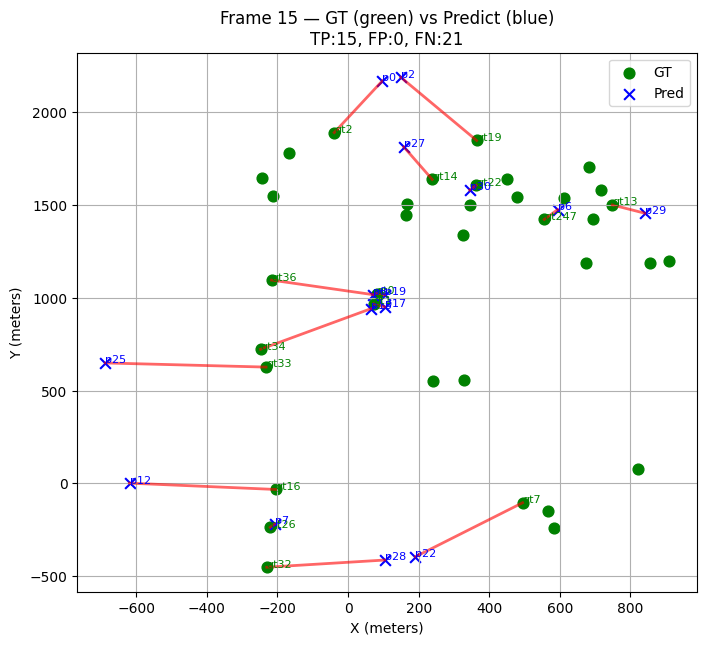

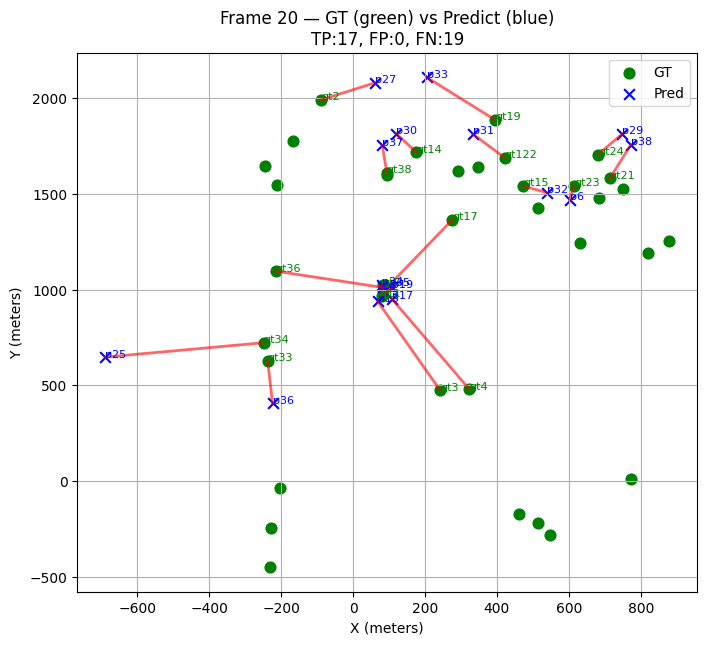

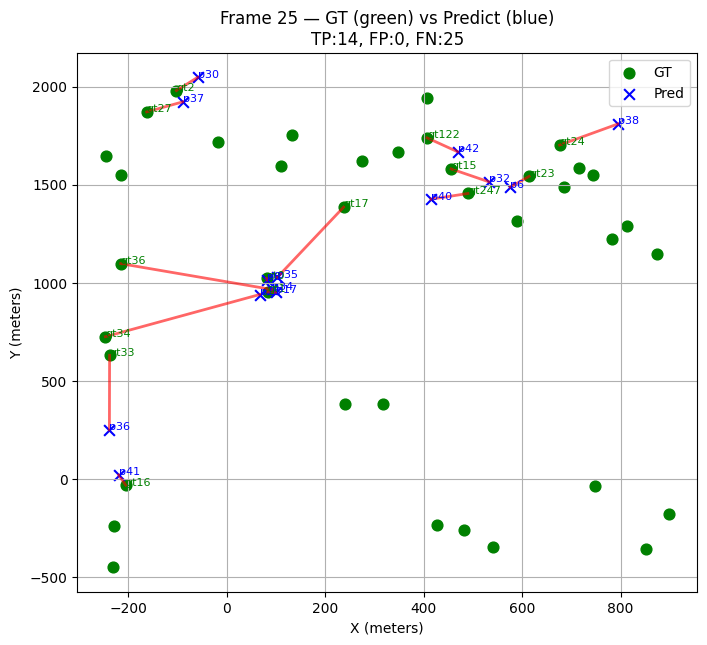

Total: TP=1034 FP=832 FN=640 | ID switches=534
Precision: 0.554 | Recall: 0.618

Classification Report (sklearn):
              precision    recall  f1-score   support

  Non-object       0.00      0.00      0.00       832
      Object       0.55      0.62      0.58      1674

    accuracy                           0.41      2506
   macro avg       0.28      0.31      0.29      2506
weighted avg       0.37      0.41      0.39      2506


MOTA: -0.198
MOTP (mean distance): 269.12 meters
ID switches: 534


In [38]:
from scipy.optimize import linear_sum_assignment
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

DIST_THRESH = 600.0
frames = sorted(set(df_gt_world['frame']) & set(df_tracks['frame']))

tp_total, fp_total, fn_total = 0, 0, 0
all_true, all_pred = [], []
id_switch_count = 0
motp_distances = []
prev_matches = {}

# Visualize N frames (set as needed)
N_vis = 5
for i, frame_idx in enumerate(frames):
    gt_f = df_gt_world[df_gt_world['frame']==frame_idx]
    pr_f = df_tracks[df_tracks['frame']==frame_idx]
    gt_coords = gt_f[['X','Y']].to_numpy()
    pr_coords = pr_f[['X','Y']].to_numpy()
    gt_ids = gt_f['gtid'].to_numpy()
    pr_ids = pr_f['gid'].to_numpy()
    n_gt = len(gt_coords)
    n_pr = len(pr_coords)
    if n_gt == 0 and n_pr == 0:
        continue
    dist_mat = np.linalg.norm(gt_coords[:,None,:] - pr_coords[None,:,:], axis=2)
    cost_mat = dist_mat.copy()
    cost_mat[dist_mat > DIST_THRESH] = 1e5
    row, col = linear_sum_assignment(cost_mat)
    matches, matched_gt, matched_pr = [], set(), set()
    frame_matches = {}
    for r, c in zip(row, col):
        if dist_mat[r, c] <= DIST_THRESH:
            matches.append((r, c, dist_mat[r,c]))
            matched_gt.add(gt_ids[r])
            matched_pr.add(pr_ids[c])
            frame_matches[gt_ids[r]] = pr_ids[c]
            motp_distances.append(dist_mat[r,c])
    tp = len(matches)
    fp = n_pr - tp
    fn = n_gt - tp
    tp_total += tp
    fp_total += fp
    fn_total += fn
    for gt_id in gt_ids:
        if gt_id in matched_gt:
            all_true.append(1)
            all_pred.append(1)
        else:
            all_true.append(1)
            all_pred.append(0)
    for pr_id in pr_ids:
        if pr_id not in matched_pr:
            all_true.append(0)
            all_pred.append(1)
    if prev_matches:
        for gt_id in frame_matches:
            if gt_id in prev_matches:
                if prev_matches[gt_id] != frame_matches[gt_id]:
                    id_switch_count += 1
    prev_matches = frame_matches.copy()
    # --- Visualisation ---
    if i < N_vis:
        plt.figure(figsize=(8,7))
        plt.scatter(gt_coords[:,0], gt_coords[:,1], c='g', s=60, marker='o', label='GT')
        plt.scatter(pr_coords[:,0], pr_coords[:,1], c='b', s=60, marker='x', label='Pred')
        for (r, c, d) in matches:
            plt.plot([gt_coords[r,0], pr_coords[c,0]], [gt_coords[r,1], pr_coords[c,1]], 'r-', linewidth=2, alpha=0.6)
            plt.text(gt_coords[r,0], gt_coords[r,1], f"gt{gt_ids[r]}", color='g', fontsize=8)
            plt.text(pr_coords[c,0], pr_coords[c,1], f"p{pr_ids[c]}", color='b', fontsize=8)
        plt.legend()
        plt.title(f"Frame {frame_idx} — GT (green) vs Predict (blue)\nTP:{tp}, FP:{fp}, FN:{fn}")
        plt.xlabel('X (meters)')
        plt.ylabel('Y (meters)')
        plt.grid(True)
        plt.show()

# ---- Metrics ----
mota = 1 - (fn_total + fp_total + id_switch_count) / (tp_total + fn_total + 1e-9)
motp = np.mean(motp_distances) if motp_distances else 0.0

print(f"Total: TP={tp_total} FP={fp_total} FN={fn_total} | ID switches={id_switch_count}")
print(f"Precision: {tp_total / (tp_total + fp_total + 1e-9):.3f} | Recall: {tp_total / (tp_total + fn_total + 1e-9):.3f}")

print("\nClassification Report (sklearn):")
print(classification_report(all_true, all_pred, target_names=['Non-object','Object']))

print(f"\nMOTA: {mota:.3f}\nMOTP (mean distance): {motp:.2f} meters\nID switches: {id_switch_count}")